In [1]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import hypertools as hyp
import time, glob, itertools
import geoplot as gplt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from scipy import spatial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
%matplotlib inline

In [2]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\probability maps\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed)

In [3]:
huc12=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12= huc12.to_crs({'init': 'epsg:3732'})


In [4]:
frame['HUC_12']=frame.HUC_12.astype(str)

In [5]:
CaptainHucstable = huc12.merge(frame, on='HUC_12' )

In [6]:
inHouse=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\inhouse_elemental.csv')

In [7]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
#writes the point data to a shapefile in the dir called data.shp
geometry = [Point(xy) for xy in zip(inHouse.longitude, inHouse.latitude)]
crs = {'init': 'epsg:3732'} 
geo_df = GeoDataFrame(inHouse, crs={'init': 'epsg:4326'}, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')
projGeoDF=geo_df.to_crs(crs)

In [8]:
val_huc = gpd.sjoin(huc12, projGeoDF)

In [9]:
validations=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\validationmap.csv')

In [10]:
val_huc = val_huc.merge(validations, on='Sample_ID')

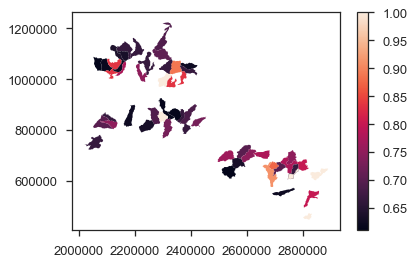

In [694]:
fig, ax = plt.subplots()
CaptainHucstable[(CaptainHucstable['element']=='ag_ppm') & (CaptainHucstable['formation'] =='Wagon Bed Formation') &
                (CaptainHucstable['bins_ppm']>=0.5) & (CaptainHucstable['prob']>0.6)].plot(ax=ax, column='prob', legend=True)
#val_huc[val_huc['Sample_ID']==validations.loc[0].Sample_ID].plot(ax=ax, color='green')


In [ ]:
df=pd.DataFrame(columns=val_huc.columns[34:-1])
df['Sample_ID'] = val_huc.Sample_ID
choices = []
for samples in tqdm(range(len(val_huc))):
    a = val_huc.loc[samples].HUC_10 #select the samples huc
    formation = val_huc.loc[samples].formation[0:10]
    for element in range(34,99):
        ppm = val_huc.columns[element] #select each element in the list
        valued = val_huc.loc[samples][element] #select each elements values 
        #from the big list, select element, formation, and concentration greater than the sample has, and create a list of the
        #basins that we should explore
        b = CaptainHucstable[(CaptainHucstable['element']== ppm) & (CaptainHucstable['formation'].str.contains(formation)) &(
            CaptainHucstable['bins_ppm']>= valued) & (CaptainHucstable['prob']>0.6)].HUC_10.values
        if a in b:
            df[ppm].iloc[samples]=1 #if the actual HUC matches the list of predicted HUC's then we record a 1
        else: 
            df[ppm].iloc[samples]=0 #if they don't match we record a 0
        choices.append(len(b))
    

df.to_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\accuracy_60percent_probability.csv')

 27%|████████████████████▊                                                         | 27/101 [49:15<2:15:00, 109.46s/it]

In [98]:
df=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\accuracy_50percent_probability.csv')

In [99]:
d2=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\intersection_huc12.csv')

In [100]:
'''
random sampling 
1. select in house sample HUC
2. select in house sample formation
3. build list of HUC's with formation
4. randomly select HUC's and compare overlap 
'''

"\nrandom sampling \n1. select in house sample HUC\n2. select in house sample formation\n3. build list of HUC's with formation\n4. randomly select HUC's and compare overlap \n"

In [107]:
df2=pd.DataFrame(columns=val_huc.columns[34:-1])
df2['Sample_ID'] = val_huc.Sample_ID

for samples in tqdm(range(len(val_huc))):
    a = val_huc.loc[samples].HUC_12 #select the samples huc
    formation = val_huc.loc[samples].formation[0:10]
    for element in range(34,99):
        ppm = val_huc.columns[element] #select each element in the list
        try:
            options = d2[d2['Unit_Name'].str.contains(formation)].HUC_12.values
            b = np.random.choice(options, np.random.randint(20)) #, np.round(len(options)*0.1).astype(int))   
            if int(a) in b:
                df2[ppm].iloc[samples]=1 #if the actual HUC matches the list of predicted HUC's then we record a 1
            else: 
                df2[ppm].iloc[samples]=0 #if they don't match we record a 0
        except:
            df2[ppm].iloc[samples]=0
        

 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [01:56<00:01,  1.16s/it]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [02:02<00:00,  1.21s/it]


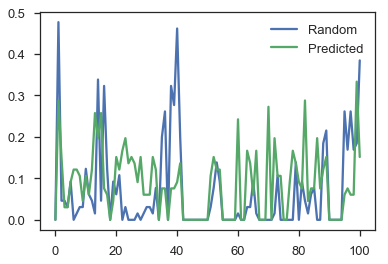

In [108]:
sampleAccuracy = []
for i in range(len(df)):
    sampleAccuracy.append(df.loc[i].values[1:-1].sum()/len(df.loc[i].values[0:-1]))

randomsampleAccuracy = []
for i in range(len(df2)):
    randomsampleAccuracy.append(df2.loc[i].values[0:-1].sum()/len(df2.loc[i].values[0:-1]))
plt.plot(randomsampleAccuracy, label='Random')
plt.plot(sampleAccuracy, label='Predicted')
plt.legend()

In [106]:
print(np.mean(randomsampleAccuracy), np.mean(sampleAccuracy))

0.07037319116527038 0.08655865586558659


In [93]:
randomsampleAccuracy
randomsampleAccuracy = [i for i in randomsampleAccuracy if i > 0]
sampleAccuracy = [i for i in sampleAccuracy if i > 0]

print(np.mean(randomsampleAccuracy), np.mean(sampleAccuracy))

0.11248423707440101 0.9848484848484845


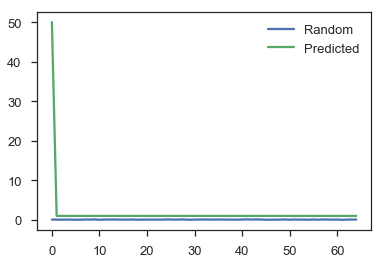

In [94]:
elementAccuracy = []
for element in range(65):
    elementAccuracy.append(df.iloc[0:,element].values.sum()/101)
    
randomelementAccuracy = []

for element in range(65):
    randomelementAccuracy.append(df2.iloc[0:,element].fillna(0).values.sum()/101)
plt.plot(randomelementAccuracy, label='Random')
plt.plot(elementAccuracy, label='Predicted')
plt.legend()

In [95]:
print(np.mean(randomelementAccuracy), np.mean(elementAccuracy))

0.06793602437166794 1.7538461538461538


In [1288]:
#df.to_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\accuracy_50percent_probability_huc12.csv')